# Uso de Python en el asistente

En esta clase vamos a ver cómo la herramienta `Code Interpreter` permite a nuestro asistente ejecutar código Python en un entorno aislado.

Comenzamos como siempre inicializando nuestro asistente e instalando las librerías pertinentes:

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00


In [2]:
import os
import openai

os.environ["OPENAI_API_KEY"] = "sk-proj-JgnyPrVpPr4xoz1FrPxiT3BlbkFJcIB6dz6ptu7gA5UifDsQ"
openai.api_key = os.environ["OPENAI_API_KEY"]
client = openai.OpenAI()

In [3]:
instrucciones_asistente = """
Eres un profesor de Python para principiantes. Los usuarios te preguntarán sobre
temas relacionados con programación y tú debes ayudarlos. Para ello les explicarás
brevemente la teoría detrás de los conceptos implicados, la sintaxis general para
resolver la duda y por último darás un ejemplo de código comentando en cada línea
de código lo que estás haciendo.
"""

En este caso a la hora de construir nuestro asistente le indicamos que vamos a utilizar la herramienta `code_interpreter`:

In [4]:
asistente_archivos = client.beta.assistants.create(
  name="Profe de Python vcode",
  description="Versión mejorada incluyendo uso de Python",
  instructions=instrucciones_asistente,
  model="gpt-4o",
  tools=[{"type": "code_interpreter"}],
)

Vamos a subir un archivo a nuestro área de trabajo (no a un vector_store). Para ello generamos el archivo y lo subimos:

In [5]:
import pandas as pd

datos = {
    'id_usuario': [1, 2, 3, 4, 5],
    'inicial_usuario': ['A', 'B', 'C', 'D', 'E'],
    'tiempo_dedicado': [10.5, 23.5, 33.0, 47.8, 51.2],
    'usa_movil': [True, False, True, False, True],
    'password': ['foo', 'bar', 'baz', 'qux', 'quux']
}
df = pd.DataFrame(datos)
print(df)
df.to_csv("dataframe_ejemplo.csv", index=False)

   id_usuario inicial_usuario  tiempo_dedicado  usa_movil password
0           1               A             10.5       True      foo
1           2               B             23.5      False      bar
2           3               C             33.0       True      baz
3           4               D             47.8      False      qux
4           5               E             51.2       True     quux


In [6]:
archivo = client.files.create(
  file=open("dataframe_ejemplo.csv", "rb"),
  purpose='assistants'
)

Podemos comprobar que se ha subido correctamente. Tras ello lo pasamos como argumento dentro de las `tool_resources`:

In [7]:
asistente_archivos = client.beta.assistants.update(
    asistente_archivos.id,
    tools=[{"type": "code_interpreter"}],
    tool_resources={
      "code_interpreter": {
      "file_ids": [archivo.id]
    }
  }
)

In [8]:
hilo = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "¿Podrías generar una gráfica sobre cuánto tiempo dedica cada usuario que usa móvil y escribirla en un archivo .jpg?",
    }
  ]
)

In [9]:
ejecucion = client.beta.threads.runs.create(
  thread_id=hilo.id,
  assistant_id=asistente_archivos.id
)

print(ejecucion)


Run(id='run_d0g6zD51x9pSoNwn9UG3sNwK', assistant_id='asst_nIcYxH4wptX4CEBEPFAijZil', cancelled_at=None, completed_at=None, created_at=1718212528, expires_at=1718213128, failed_at=None, incomplete_details=None, instructions='\nEres un profesor de Python para principiantes. Los usuarios te preguntarán sobre\ntemas relacionados con programación y tú debes ayudarlos. Para ello les explicarás\nbrevemente la teoría detrás de los conceptos implicados, la sintaxis general para\nresolver la duda y por último darás un ejemplo de código comentando en cada línea\nde código lo que estás haciendo.\n', last_error=None, max_completion_tokens=None, max_prompt_tokens=None, metadata={}, model='gpt-4o', object='thread.run', parallel_tool_calls=True, required_action=None, response_format='auto', started_at=None, status='queued', thread_id='thread_FAiYLKIk7aQFJjD5m273tU7v', tool_choice='auto', tools=[CodeInterpreterTool(type='code_interpreter')], truncation_strategy=TruncationStrategy(type='auto', last_mess

Comprobamos el resultado de la ejecución:

In [11]:
client.beta.threads.messages.list(hilo.id)

SyncCursorPage[Message](data=[Message(id='msg_YZ6hjGMYVlq3ZuYBN7ymS5o3', assistant_id='asst_nIcYxH4wptX4CEBEPFAijZil', attachments=[Attachment(file_id='file-Egs2hpLF7Xnm3Hi11K4DG3xB', tools=[CodeInterpreterTool(type='code_interpreter')])], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-nhNcw4buqA4hF0s71AR2rTnw', detail=None), type='image_file'), TextContentBlock(text=Text(annotations=[FilePathAnnotation(end_index=284, file_path=FilePath(file_id='file-Egs2hpLF7Xnm3Hi11K4DG3xB'), start_index=238, text='sandbox:/mnt/data/usuarios_tiempo_dedicado.jpg', type='file_path')], value='Aquí tienes la gráfica que muestra el tiempo dedicado por cada usuario que usa móvil. La gráfica también se ha guardado en un archivo .jpg.\n\nPuedes descargar el archivo desde el siguiente enlace:\n\n[Descargar usuarios_tiempo_dedicado.jpg](sandbox:/mnt/data/usuarios_tiempo_dedicado.jpg)\n\nSi necesitas algo más o ajustes adicionales, házmelo saber.'), type='text')], created_a

Podemos observar que en las primeras líneas parece que se ha generado una imagen. Si vamos al sistema de archivos de OpenAI podemos ver cómo la imagen se ha almacenado. Además si las descargamos podemos echarle un ojo.

Veamos cómo podríamos hacer esto mismo en Python. Lo primero que tenemos que localizar es el identificador del archivo. Para ello recurrimos a los pasos de ejecución:

In [12]:
pasos_ejecucion = client.beta.threads.runs.steps.list(
  thread_id=hilo.id,
  run_id=ejecucion.id
)
print(pasos_ejecucion)

SyncCursorPage[RunStep](data=[RunStep(id='step_QjVAftMtqTuXwzQ2TZURgxZc', assistant_id='asst_nIcYxH4wptX4CEBEPFAijZil', cancelled_at=None, completed_at=1718212561, created_at=1718212559, expired_at=None, failed_at=None, last_error=None, metadata=None, object='thread.run.step', run_id='run_d0g6zD51x9pSoNwn9UG3sNwK', status='completed', step_details=MessageCreationStepDetails(message_creation=MessageCreation(message_id='msg_YZ6hjGMYVlq3ZuYBN7ymS5o3'), type='message_creation'), thread_id='thread_FAiYLKIk7aQFJjD5m273tU7v', type='message_creation', usage=Usage(completion_tokens=79, prompt_tokens=786, total_tokens=865), expires_at=None), RunStep(id='step_Aw6oOonFgpC69E2wQ5ClOwGM', assistant_id='asst_nIcYxH4wptX4CEBEPFAijZil', cancelled_at=None, completed_at=1718212559, created_at=1718212549, expired_at=None, failed_at=None, last_error=None, metadata=None, object='thread.run.step', run_id='run_d0g6zD51x9pSoNwn9UG3sNwK', status='completed', step_details=ToolCallsStepDetails(tool_calls=[CodeInt

In [13]:
id_archivo = pasos_ejecucion.data[1].step_details.tool_calls[0].code_interpreter.outputs[0].image.file_id

In [14]:
imagen = client.files.content(id_archivo)
imagen_bytes = imagen.read()

with open("resultado_gra1fica.png", "wb") as file:
    file.write(imagen_bytes)

Haciendo doble click en el archivo también podemos visualizarlo:

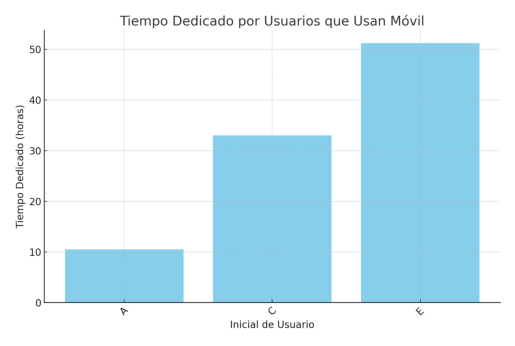

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("resultado_grafica.png")
plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.show()

## Cierre

En este cuaderno hemos visto cómo podemos hacer llamadas a Python desde un asistente y hemos aprendido un poco más sobre el trabajo con archivos en asistentes.

Como en los casos anteriores te animo a probar su funcionamiento con otros tipos de archivos para ver hasta qué punto la herramienta permite una enorme versatilidad.